# First steps using mne


## Imports

In [5]:
import os
from os import path
import mne
import numpy as np
import matplotlib.pyplot as plt

os.chdir("..")
import helpers
os.chdir('analysis-adelie')

%matplotlib qt

## Config

In [205]:
# This is the config. Add any value that you deem necessary. This should contain everything that belongs to the setup, the filtering pipeline, etc.

cfg = {
    'paths': {
        'base': '../../data/AlphaTheta',
        'subjects': {
            'sam': {
                'prefix': '/sam-AlphaTheta',
                'recordings': {
                    'baseline': [
                        '20200304-144100',
                        '20200304-144601'
                    ],
                    'meditation': [
                         '20200304-144933'   
                    ]
                },
                'channels_path': 'channelsList.txt'
            },
            'adelie': {
                'prefix': '/adelie-AlphaTheta',
                'recordings': {
                    'baseline': [
                        '20200304-151358',
                    ],
                    'meditation': [
                        '20200311-104132',
                    ]
                },
                'channels_path': 'channelsList.txt'
            }
        }
    },
    'columns_to_remove': [
        'TRIGGER', 'X1', 'X2', 'X3',
    ],
    'default_signal_crop': np.s_[3000:-3000], # this corresponds to ~1 second at the beginning and end, given by the sampling frequency
    'sampling_frequency': 300,
    'bands': {
        'gamma': [40, 100],
        'beta':  [12, 40],
        'alpha': [8, 12],
        'theta': [4, 8],
        'delta': [0.5, 4]
    }
}

## Base I/O

In [123]:
baseline_adelie_pd = helpers.load_signal_data('baseline1', subject='adelie', config=cfg)
meditation_adelie_pd = helpers.load_signal_data('meditation1', subject='adelie', config=cfg)

In [36]:
electrode_of_interest = 'O2'

In [35]:
bandpower_adelie = {
    'baseline': helpers.get_bandpower_for_electrode(baseline_adelie_pd, electrode=electrode_of_interest, config=cfg),
    'meditation': helpers.get_bandpower_for_electrode(meditation_adelie_pd, electrode=electrode_of_interest, config=cfg)
}

NameError: name 'electrode_of_interest' is not defined

In [124]:
helpers.plot_raw_signal(baseline_adelie_pd);

In [38]:
helpers.plot_raw_signal(meditation_adelie_pd);

In [37]:
aggregated_power_adelie = helpers.aggregate_bandpower(baseline=bandpower_adelie['baseline'], signal=bandpower_adelie['meditation'])
aggregated_power_adelie

NameError: name 'bandpower_adelie' is not defined

## Helpers

In [207]:
def get_channelsList(config, subject='adelie'):
    subject_paths = helpers.get_config_value(config, 'paths', 'subjects', subject)
    base_path = helpers.get_config_value(config, 'paths', 'base')
    file_path = f"{base_path}/{subject_paths['prefix']}/offline/fif/{subject_paths['channels_path']}"
    with open(file_path, 'r') as channels_file:
        all_channels = channels_file.read().strip()
    return [channel for channel in all_channels.split('\n') if channel not in config['columns_to_remove']]

def load_raw_mne_from_fif(data_type, subject='adelie', recording=0, montage='standard_1020', config=cfg):
    """loads the data and returns an instance of mne.Raw
    
    Parameters
    ----------
    data_type : string
      type of the data, right now two options are valid: `baseline` or `meditation`
    subject: string
      name of the subject
    recording: int
      number of recording, if you have multiple of same type and subject
    montage: string
      the type of montage that was used for the recording see: https://mne.tools/dev/generated/mne.channels.make_standard_montage.html
      
    Returns
    -------
    a mne.Raw instance that has the correct montage and info and is ready to be plotted
    """
    subject_paths = helpers.get_config_value(config, 'paths', 'subjects', subject)
    base_path = helpers.get_config_value(config, 'paths', 'base')
    recording_id = helpers.get_config_value(subject_paths, 'recordings', data_type)[recording]
    file_path = f"{base_path}{subject_paths['prefix']}/offline/fif/{recording_id}-raw.fif"
    
    # Create a digitization of the montage
    digitization = mne.channels.make_standard_montage(montage)
    channels = get_channelsList(config, subject=subject)
    
    # Read from fif file
    raw = mne.io.read_raw_fif(file_path, preload=True)
    
    # Create info with some useful information
    info = mne.create_info(channels, sfreq=config['sampling_frequency'], ch_types='eeg')
    raw.info = info
    
    # set the montage
    raw.set_montage(digitization)
    
    raw = raw.pick_types(eeg=True, stim=False)
    raw.set_eeg_reference(projection=True).apply_proj()
    
    return raw

## Some interesting plots of raw data and CSD data

In [208]:
baseline_adelie_mne = load_raw_mne_from_fif('baseline')
baseline_adelie_csd = mne.preprocessing.compute_current_source_density(adelie_baseline_mne)

Opening raw data file ../../data/AlphaTheta/adelie-AlphaTheta/offline/fif/20200304-151358-raw.fif...
Isotrak not found
    Range : 0 ... 38041 =      0.000 ...   126.803 secs
Ready.
Reading 0 ... 38041  =      0.000 ...   126.803 secs...
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm


In [209]:
meditation_adelie_mne = load_raw_mne_from_fif('meditation')
meditation_adelie_csd = mne.preprocessing.compute_current_source_density(meditation_adelie_mne)

Opening raw data file ../../data/AlphaTheta/adelie-AlphaTheta/offline/fif/20200311-104132-raw.fif...
Isotrak not found
    Range : 0 ... 47051 =      0.000 ...   156.837 secs
Ready.
Reading 0 ... 47051  =      0.000 ...   156.837 secs...
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm


In [210]:
baseline_adelie_mne.plot(scalings='auto');
baseline_adelie_mne.plot_psd();

Effective window size : 6.827 (s)


In [211]:
baseline_adelie_csd.plot(scalings='auto');
baseline_adelie_csd.plot_psd();

Effective window size : 6.827 (s)


In [212]:
meditation_adelie_mne.plot(scalings='auto');
meditation_adelie_mne.plot_psd();

Effective window size : 6.827 (s)


In [213]:
meditation_adelie_csd.plot(scalings='auto');
meditation_adelie_csd.plot_psd();

Effective window size : 6.827 (s)


## Taking a look at events

In [29]:
adelie_baseline_mne.stim_channel = 'TRIGGER'

event_id = {
    "END": 16,
    "INIT": 15,
}
epochs = mne.Epochs(adelie_baseline_mne, events, event_id=event_id, tmin=-0.2, tmax=.5,
                    preload=True)
evoked = epochs['END'].average()

2 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 2 events and 211 original time points ...
0 bad epochs dropped


Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm


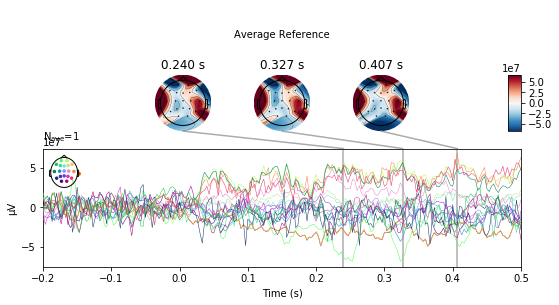

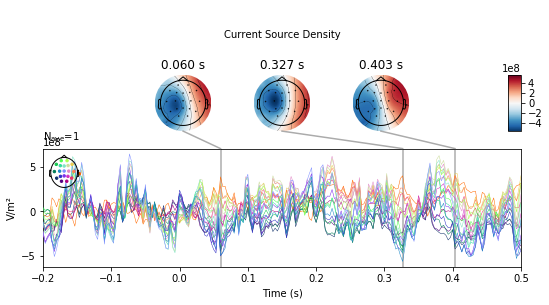

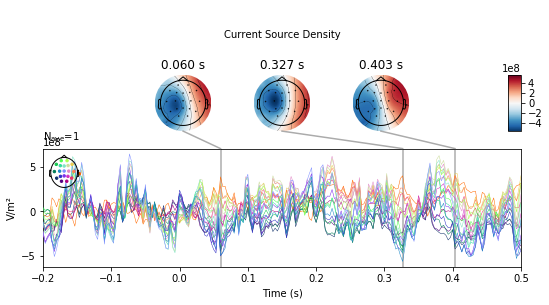

In [25]:
times = np.array([-0.1, 0., 0.05, 0.1, 0.15])
evoked_csd = mne.preprocessing.compute_current_source_density(evoked)
evoked.plot_joint(title='Average Reference', show=False)
evoked_csd.plot_joint(title='Current Source Density')

In [30]:
fig, ax = plt.subplots(4, 4)
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(10, 10)
for i, lambda2 in enumerate([0, 1e-7, 1e-5, 1e-3]):
    for j, m in enumerate([5, 4, 3, 2]):
        this_evoked_csd = mne.preprocessing.compute_current_source_density(
            evoked, stiffness=m, lambda2=lambda2)
        this_evoked_csd.plot_topomap(
            0.1, axes=ax[i, j], outlines='skirt', contours=4, time_unit='s',
            colorbar=False, show=False)
        ax[i, j].set_title('stiffness=%i\nλ²=%s' % (m, lambda2))

Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin

In [45]:
fig = dig.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
dig.plot(kind='topomap', show_names=False);

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [ ]:
event_id = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
            'visual/right': 4, 'smiley': 5, 'button': 32}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.2, tmax=.5,
                    preload=True)
evoked = epochs['auditory'].average()

## For reference only

In [6]:
dig = mne.channels.make_standard_montage('standard_1020')
channels = ['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'Pz', 'Fp1', 'Fp2','T3', 'T5', 'O1', 'O2', 'F7', 'F8', 'A2', 'T6', 'T4']
adelie_info = mne.create_info(list(meditation_adelie_pd.columns.values), 300, ch_types='eeg')
meditation_adelie_mne = mne.io.RawArray(meditation_adelie_pd.values.transpose()/1000000, adelie_info)
meditation_adelie_mne = meditation_adelie_mne.pick_types(meg=False, eeg=True, eog=True, ecg=True, stim=False, exclude=baseline_adelie_mne.info['bads'])
meditation_adelie_mne.set_eeg_reference('average', projection=True).apply_proj()
meditation_adelie_mne.set_montage(dig)

meditation_adelie_csd = mne.preprocessing.compute_current_source_density(meditation_adelie_mne)

NameError: name 'meditation_adelie_pd' is not defined